In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from sparix.trans import Pad
from sparix.modeling.transformer import Transformer
from sparix.data  import FrameDataset

In [3]:
import h5py
import math
import random

In [4]:
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# path_h5 = "3IYF.Fibonacci.h5"
# with h5py.File(path_h5, "r") as fh:
#     data = fh.get("intensities")[:100]

In [7]:
path_h5 = "3IYF.Fibonacci.h5"
fh = h5py.File(path_h5, "r")

In [8]:
frame_source = fh["intensities"]
frame_source.shape

(5000, 1, 156, 156)

In [9]:
B, C, H, W = frame_source.shape

H_patch = 16
W_patch = 16
H_padded = math.ceil(H / H_patch) * H_patch
W_padded = math.ceil(W / W_patch) * W_patch
H_padded, W_padded

(160, 160)

In [10]:
pad = Pad(H_padded, W_padded)

In [11]:
frame_idx_list = range(4000)
Hp, Wp = H_patch, W_patch
num_frame_in_context = 4
sample_size = 100
fd = FrameDataset(frame_source, frame_idx_list, num_frame_in_context, Hp, Wp, sample_size, pad)

In [ ]:
fh.close()

In [ ]:
156 / 4

In [12]:
context, target = fd[0]

In [13]:
context.shape, target.shape

((400, 16, 16), (400, 16, 16))

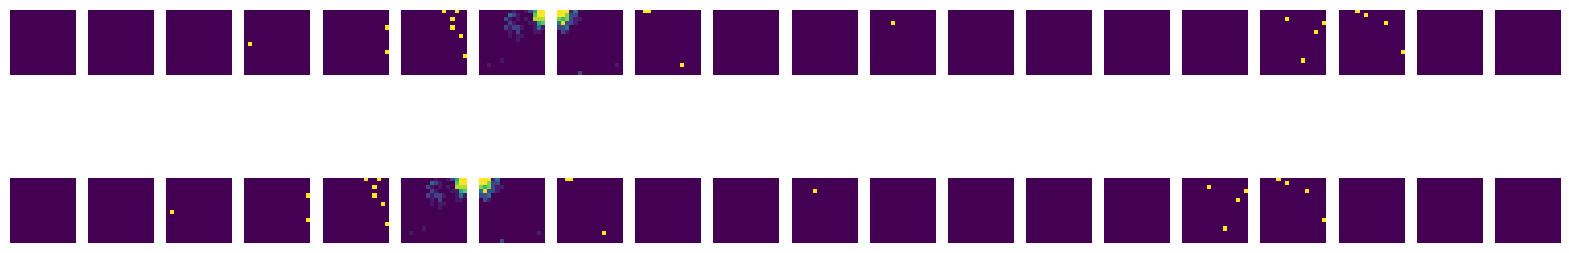

In [24]:
start_idx = random.choice(range(context.shape[0] - H_padded))
ncols = 20
nrows = 2
fig   = plt.figure(figsize = (20,4))
gspec = fig.add_gridspec( nrows, ncols, )

ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

for col in range(ncols):
    ax = ax_list[col]
    data_viz = context[start_idx + col]
    vmin = data_viz.mean()
    vmax = data_viz.mean() + 4 * data_viz.std()
    ax.imshow(data_viz, interpolation = 'none', vmin = vmin, vmax = vmax)

for col in range(ncols):
    ax = ax_list[ncols + col]
    data_viz = target[start_idx + col]
    vmin = data_viz.mean()
    vmax = data_viz.mean() + 4 * data_viz.std()
    ax.imshow(data_viz, interpolation = 'none', vmin = vmin, vmax = vmax)

# Apply style...
for ax in ax_list:
    ax.set_xticks([])
    ax.set_yticks([])

    # Hide the frame box
    ax.spines['top'   ].set_visible(False)
    ax.spines['right' ].set_visible(False)
    ax.spines['left'  ].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [ ]:
Hp, Wp = 13, 13

In [ ]:
data_reshaped = data.reshape(B, C, H//Hp, Hp, W//Wp, Wp).swapaxes(3,4)    # data.reshape(B, C, H//Hp, Hp, W//Wp, Wp).transpose(0, 1, 2, 4, 3, 5)
data_reshaped.shape

In [ ]:
data.reshape(B, C, H//Hp, Hp, W//Wp, Wp).swapaxes(3,4).reshape(B * C * H * W // Hp // Wp, Hp, Wp).shape

In [ ]:
data.shape

In [ ]:
fig = plt.figure(figsize = (4, 4))
vmin = data[0, 0].mean()
vmax = data[0, 0].mean() + 4 * data[0, 0].std()
plt.imshow(data[0, 0], interpolation = 'none', vmin = vmin, vmax = vmax)

In [ ]:
ndiv  = H//Hp
ncols = ndiv
nrows = ndiv
fig   = plt.figure(figsize = (4,4))
gspec = fig.add_gridspec( nrows, ncols, )
ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

for row in range(nrows):
    for col in range(ncols):
        idx = col + ncols * row
        ax = ax_list[idx]
        data_viz = data_reshaped[0, 0][row][col]
        ax.imshow(data_viz, interpolation = 'none', vmin = vmin, vmax = vmax)

# Apply style...
for ax in ax_list:
    ax.set_xticks([])
    ax.set_yticks([])

    # Hide the frame box
    ax.spines['top'   ].set_visible(False)
    ax.spines['right' ].set_visible(False)
    ax.spines['left'  ].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [ ]:
num_patch, Hp, Wp = context.shape

In [ ]:
tok_size            = Hp * Wp
embd_size           = 768    # (google's pretrained ViT)
context_length      = num_frame_in_context * num_patch
num_blocks          = 4
num_heads           = 4
uses_causal_mask    = True
attention_dropout   = 0.1
residual_dropout    = 0.1
feedforward_dropout = 0.1
model = Transformer(tok_size            = tok_size,
                    embd_size           = embd_size,
                    context_length      = context_length,
                    num_blocks          = num_blocks,
                    num_heads           = num_heads,
                    uses_causal_mask    = uses_causal_mask,
                    attention_dropout   = attention_dropout,
                    residual_dropout    = residual_dropout,
                    feedforward_dropout = feedforward_dropout,)
model.to(device)

In [ ]:
sum(p.numel() for p in model.parameters())/1e6    # M parameters

In [ ]:
context.shape

In [ ]:
606454677504 / 1e9